<a href="https://colab.research.google.com/github/clysdid/from_scratch/blob/master/1_Transformer_from_scratch_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
# import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
# Some convenience helper functions used throughout the notebook
def is_interactive_notebook():
    return __name__ == "__main__"

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)

class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None

class DummyScheduler:
    def step(self):
        None

### Model Architecture
- encoder-decoder구조
- encoder: 인풋 시퀀스를 벡터 표현으로 변환
- decoder: 아웃풋 시퀀스를 생성하는 것. 각 스텝은 모두 auto-regressive (그 다음 토큰을 예측할 때, 계속 추가적인 인풋을 사용하는 것)



- src: source
- tgt : target
- src_mask(source_mask): 역할: 소스 시퀀스의 패딩 토큰(padding token)을 무시하거나, 문맥에 따라 처리할 필요가 없는 토큰을 필터링하는 역할을 합니다. 예를 들어, 입력 문장이 "I love NLP"이고, 패딩 토큰이 추가된 경우 "I love NLP <pad> <pad>"가 되는데, src_mask는 <pad> 토큰을 무시하도록 합니다.
- tgt_mask: 타겟 시퀀스의 패딩 토큰을 무시하거나, 다음 단어를 예측할 때, 미래의 단어를 참조하지 못하도록 함.

In [ ]:
class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def forward(self, src, tgt, src_mask, tgt_mask): # encoder-decode를 이어주는 역할
    #"Take in and process masked src and target sequences."
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
# 트랜스포머 마지막 단의 linear layer + softmax
class Generator(nn.Module):
  # define stanard linear + softmax 생성 단계
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return F.log_softmax(self.proj(x) , dim=-1)

### Encoder
- n=6으로 동일한 6개 레이어를 쌓음

In [ ]:
def clones(module, N):
  # n 개의 동일한 레이어 생성
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

- 정규화하는 이유: 1) 내부 공변량 변화 감소를 통한 모델의 안정적 학습, 2) 일반화 성능 향상, 3) 배치 정규화와 달리 레이어  정규화는 배치크기에 독립적. 시퀀스 데이터이기 때문에 다른 배치크기에서도 안정적으로 작동 가능
- 레이어 정규화는 레이어 전체를 정규화시키는 것을 의미함. 따라서 미니배치 사이즈에 영향받지 않음.

In [ ]:
class Encoder(nn.Module):
  # N개의 레이러를 쌓기 위한 핵심 인코더

  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size) # 정규화

  def forward(self, x, mask):
    # 각 층에 인풋(과 마스크)를 매턴마다 넘김  # 각각 레이어에 인풋과 마스크 통과

    for layer in self.layers:
        x = layer(x, mask)
    return self.norm(x)

- 레이어 normalization에 나오는 2개의 서브레이어에 대해서는 residual connection 활용
- x.mean(-1, keepdim=True)는 주어진 텐서 x에 대해 특정 축(axis)에 대한 평균을 계산하는 구문입니다.

  - x.mean(-1, keepdim=True)
  - x.mean(): x 텐서의 평균을 계산합니다.
  - -1: 마지막 축(axis)에 대해 평균을 계산합니다.
  - keepdim=True: 평균을 계산한 결과를 원래의 차원 수와 동일하게 유지합니다.
- eps: 0으로 나누는 문제를 해결하기 위해, 아주 값을 더해주는 것

- 코드의 의미와 계산 과정
  1. 정규화(Normalization):

    (x - mean) / (std + self.eps): 입력 텐서 x에서 평균 mean을 빼고 표준편차 std로 나눕니다.
    self.eps는 수치 안정성을 위해 추가된 값입니다.
  2. 선형 변환(Linear Transformation):

    self.a_2 * normalized_value + self.b_2: 정규화된 값에 학습 가능한 매개변수 a_2를 곱하고, b_2를 더합니다.

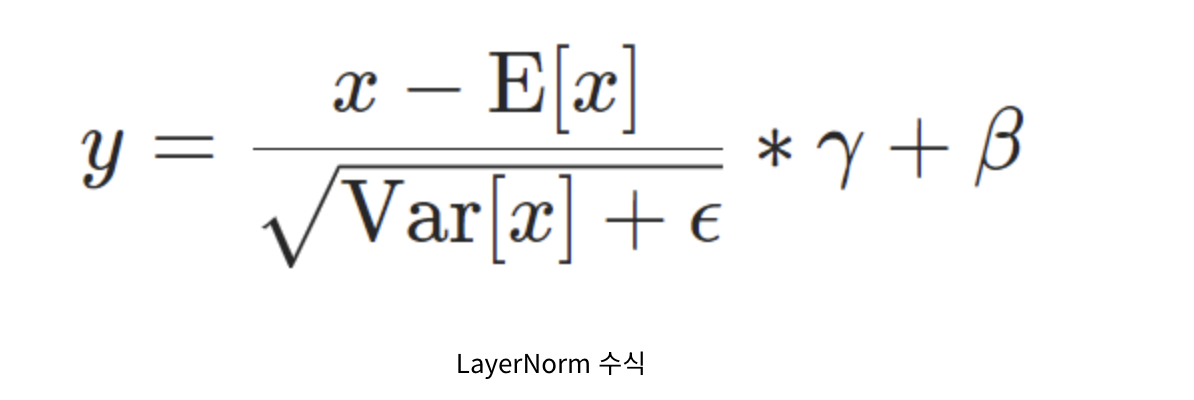

In [ ]:
class LayerNorm(nn.Module):
  # layernorm module 구성

  def __init__(self, features, eps = 1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim =True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x-mean) / (std+self.eps) + self.b_2 #텐서 x에 대해 정규화. 텐서의 각 요소를 표준화하고, 그 결과를 학습 가능한 매개변수를 사용하여 선형 변환하는 과정

- residual conneciton: 주어진 층(layer)의 결과를 멀리있는 다음층에도 직접 더하는 방식입니다. 이를 통해, 네트워크의 깊이가 깊어져도 학습이 잘 이루어지도록 합니다.
- 기울기 소실 문제 완화: 역전파 동안 기울기가 직접 입력으로 전달되기 때문에, 기울기 소실 문제가 완화됩니다.
더 깊은 네트워크 학습 가능: 네트워크가 더 깊어질수록, 일반적으로 학습이 어려워지지만, Residual Connection을 사용하면 더 깊은 네트워크도 효과적으로 학습할 수 있습니다.

In [ ]:
# add * norm 부분
class SublayerConnection(nn.Module):
  # layer norm 이후에 나오는 resuidual connection 코드의 간결성을 위해 정규화를 마지막이 아닌 처음에 수행
  # layer norm의 잔차를 더해줌.
  def __init__(self,size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    # 같은 크기의 어떠한 서브레이어 residual connection 적용
    return x + self.dropout(sublayer(self.norm(x))) # 정규화랑 dropout까지 한 결과를 기존의 원래값인 x에 더해주는 것

- 각각의 레이어는 2개의 서브레이어인 (multi head attention, position wise fully connected feed forward network)으로 이루어짐
- q: encode/decode 결과  (target)
- K: input
- v: 계산결과

1. Encoder Self attention
  Q = K = V = Our source sentence(English)

2. Decoder Self attention
  Q = K = V = Our target sentence(German)

3.  Decoder-Encoder attention
  Q = Our target sentence(German)
  K = V = Our source sentence(English)

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"     # 논문 1 왼쪽 커넥션

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2) # 인코더에 add*norm 2번 들어가기 때문임.
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))  # (query,key, value, mask)를 의미. # self_attn은 q=k=v기 때문에 모두 x로 표시
        return self.sublayer[1](x, self.feed_forward)

- Encoder layer는 두개의 sublayer로 구성됨.
- 이때 sublayer는 self attenton과 ffn을 말함

### Decoder

In [ ]:
class Decoder(nn.Module):
  # masking N개 레이어
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memeory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memeory, src_mask, tgt_mask)
    return self.norm(x)

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size,dropout),3)

  def forward(self, x, memory, src_mask, tgt_mask):
    # 1번 그림의 오른쪽 커넥션
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) #x: query, m: encoder output (key, value)
    return self.sublayer[2](x, self.feed_forward)

In [ ]:
# 그 다음에 올 단어 마스킹

def subsequent_mask(size):
  attn_shape = (1, size, size)
  subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8) # 삼각행렬 생성. 위 상삼각행렬은1, 하삼각행렬은 0
  return subsequent_mask ==0

### attention

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
  # 내적연산
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k)
  if mask is not None:
    scores = scores.masked_fill(mask==0, -1e9) # mask 0을 -1e9로 변환 -> softmax 통과한 값이 0이 되게끔 하는 것.# mask 0은 무시하는 토큰
  if dropout is not None:
    p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn # attention*score = attention, attention_score 반환

In [ ]:
class MultiHeadAttention(nn.Module):
  def __inti__(self, h, d_model, dropout=0.1):
    super(MultiHeadAttention, self).__init__()
    assert d_model %h==0 # assert 뒤의 조건이 True가 아니면 AssertError 발생
    # d_v = d_k 라고 가정
    self.d_k = d_model//h # 모델을 head 수 만큼 나눠줌.
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model),4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    # 2번 그림
    if mask is not None:
      mask = mask.unsqueeze(1) # 모든 head에 대해 같은 마스크 적용. 차원 생성 (<-> squeeze: 차원삭제)
    nbatches = query.size(0)

    # h * d_k에 대해 선형 projection 적용
    query, key, value = [
        lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
        for lin, x, in zip(self.linears, (query, key, value))
    ]

    # 배치 dksdml projected vector에 어텐션 적용
    x, self_attn = attention(query, key, value, mask=mask, dropout=self.dropout)

    # 마지막 선형특에서 concat
    x = (x.tranpose(1,2).contigous().view(nbatches, -1, self.h*self.d_k)) #contigous(): 메모리적으로 비연속적인 텐서를 연속적으로 만들어 연산이 가능하게 함.
    del query
    del key
    del value
    return self.linears[-1](x)

In [7]:
import torch
x = torch.randn(2,3,4)
print(x)
print(x.shape)
print(x.transpose(1,2)) # (2,3,4) -> (2,4,3)
print(x.shape)

tensor([[[ 0.8961,  0.1012,  2.4126,  0.1851],
         [-1.0262,  1.0998, -0.8699, -0.2121],
         [ 1.2026,  0.0263, -0.1595,  1.4189]],

        [[ 0.1604,  0.8029, -0.2120,  0.7522],
         [-0.2628,  0.3969,  0.8293, -0.5287],
         [-1.4368, -0.2384, -0.2043, -0.1829]]])
torch.Size([2, 3, 4])
tensor([[[ 0.8961, -1.0262,  1.2026],
         [ 0.1012,  1.0998,  0.0263],
         [ 2.4126, -0.8699, -0.1595],
         [ 0.1851, -0.2121,  1.4189]],

        [[ 0.1604, -0.2628, -1.4368],
         [ 0.8029,  0.3969, -0.2384],
         [-0.2120,  0.8293, -0.2043],
         [ 0.7522, -0.5287, -0.1829]]])
torch.Size([2, 3, 4])


In [3]:
a = 3
assert a==2 # 틀렷으므로 assertion error 발생

AssertionError: 

### Position-wise Feed-Forward Networks

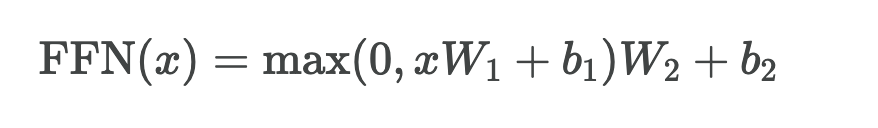

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(self.w_1(x).relu())) # 2개의 선형 층 사이에는 relu로 이어져있음.

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model) # 단어들의 벡터차원을 모델의 차원으로 변환
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # 마지막에 root d_model을 곱하여 값 보정

### Positional encoding
- 병렬처리로 인해 단어의 위치를 모르기 때문에 인덱스 알려주는 역할

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout, max_len = 5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p = dropout)

    # 로그스페이스 상에서 포지셔널 인코딩 수행
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2)* -(math.log(10000.0)/ d_model))

    pe[:, 0::2] = torch.sin(position*div_term) # 짝수번째에는 sin
    pe[:, 1::2] = torch.cos(position*div_term) # 홀수번째에는 cos
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x+self.pe[:, :x.size(1)].requires_grad_(False)
    return self.dropout(x)

### 최종 모델 구성

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
  c = copy.deepcopy
  attn = MultiHeadAttention(h, d_model)
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
      Encoder(EncoderLayer(d_model , c(attn), c(ff), dropout), N),
      Decoder(DecoderLayer(d_model , c(attn), c(attn), c(ff), dropout), N),
      nn.Sequentioal(Embeddings(d_model, src_vocab), c(position)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
      Generator(d_model, tgt_vocab),
  )

  for p in model.parametrs():
    if p.dim()> 1:
      nn.init.xavier_uniform_(p)
  return model

참고 사이트:
- https://github.com/HosseinZaredar/Transformer-from-Scratch/blob/main/transformer_from_scratch.ipynb
- https://nlp.seas.harvard.edu/annotated-transformer/
- https://codingopera.tistory.com/74

- batch_size: 한번의 학습에서 사용되는 데이터 크기
- iteration: 한번의 배치를 모델에 입력하고 학습하는 과정
- epoch: 데이터셋 전체를 한번 학습하는 과정